In [1592]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [1593]:
import numpy
import torch
import torchvision
import typing
import numpy

from holo.prettyFormats import prettyPrint, prettyTime
from holo.__typing import assertIsinstance

In [1594]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [1595]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper2
import modelsParameters

def cell():
    global handleDatas, train, MoE_models, basicModels, modelsParameters
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    modelsParameters = importlib.reload(modelsParameters)
    MoE_models.paper2 = importlib.reload(MoE_models.paper2)

cell();

In [1596]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256, dataAugemnt="basic+degrade")

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10](total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]


In [1652]:
datasHandler_noAugments = handleDatas.HandleImagesClassifDatas.merge(
    datasHandler, trainProp=0.0001, batchSizeTrain=256, batchSizeTest=256, dataAugemnt='mostBasic')

loaded Merged[Merged[Cifar10]](total: 60000), train: 6 [1 batches] | test: 59994 [235 batches]


-0.41379434389818925
0.8345921523869038


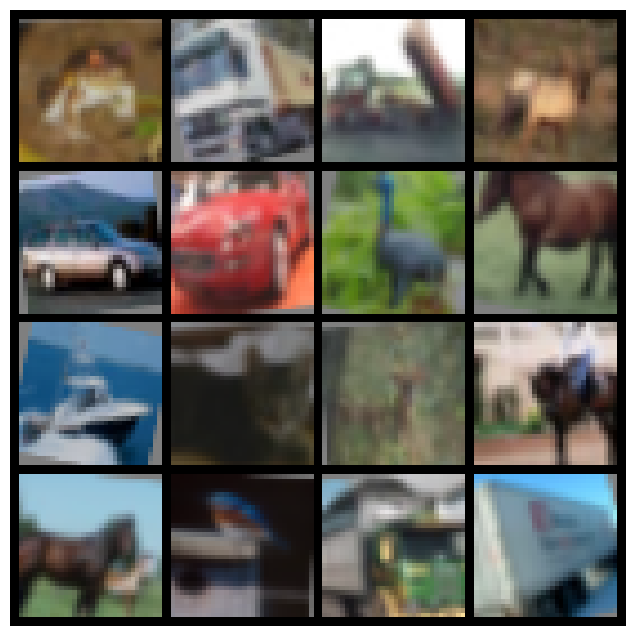

In [1641]:
def cell():
    import matplotlib.pyplot as plt
    
    K = 16
    Ks = (K ** 0.5).__ceil__()
    
    plt.figure(figsize=(2*Ks,2*Ks))
    plt.axis('off')
    images = [datasHandler.full_dataset[i]['image'] for i in range(K)]
    print((sum(img.mean().item() for img in images)/len(images)))
    print((sum(img.std().item() for img in images)/len(images)))
    plt.imshow(torchvision.utils.make_grid(
        images, nrow=Ks, normalize=True, scale_each=False).permute((1, 2, 0)))
    plt.show()

cell(); del cell

In [1643]:
model = moeModel = MoE_models.paper2.VisionModelMoe.get_cifar_v1(
    nbClasses=datasHandler.nbClasses, wImp=0.1, wLoad=0.1,
    nbExperts=1, topK=1, modelConfig="medium", memoryMode=False).to(device)
lossFunc = torch.nn.CrossEntropyLoss().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

#print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
#basicModels.countLayersparameters(model)
modelsParameters.ModelTreeNode("Model", model).print(showTrainable=False, end=("experts", "gating", "Block_CNN"))

trainer = train.TrainerClassif_MoE2(model=model, optimizer=optim, criterion=lossFunc, device=device)

# test the model
_ = model(datasHandler.full_dataset[0]['image'].to(device)[None, ...].repeat((1, 1, 1, 1)))
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

└── Model: 497_916 params
    └── blocks: 497_916 params
        ├── Block_CNN[0]: 432 params
        ├── Block_CNN[1]: 4_672 params
        ├── Block_CNN[2]: 9_216 params
        ├── Block_CNN[3]: 18_432 params
        ├── Block_CNN[4]: 73_728 params
        ├── Block_CNN[5]: 221_568 params
        ├── Dropout[6]: 0 params
        ├── Flatten[7]: 0 params
        ├── Linear[8]: 98_432 params
        └── Block_FFD_Moe[9]: 71_436 params
            ├── gating: 258 params
            └── experts: 71_178 params


In [1582]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=10);

Epoch 16, train: (loss: 0.6272, accuracy: 78.22%), test: (loss: 0.6522, accuracy: 77.47%), lr: 1.0000e-03
Epoch 17, train: (loss: 0.6115, accuracy: 78.79%), test: (loss: 0.6934, accuracy: 76.48%), lr: 1.0000e-03
Epoch 18, train: (loss: 0.5971, accuracy: 79.26%), test: (loss: 0.6455, accuracy: 77.65%), lr: 1.0000e-03
Epoch 19, train: (loss: 0.5847, accuracy: 79.58%), test: (loss: 0.6289, accuracy: 78.09%), lr: 1.0000e-03
Epoch 20, train: (loss: 0.5841, accuracy: 79.70%), test: (loss: 0.6184, accuracy: 78.47%), lr: 1.0000e-03
Epoch 21, train: (loss: 0.5722, accuracy: 80.15%), test: (loss: 0.6713, accuracy: 76.97%), lr: 1.0000e-03
Epoch 22, train: (loss: 0.5652, accuracy: 80.41%), test: (loss: 0.6217, accuracy: 78.62%), lr: 1.0000e-03
Epoch 23, train: (loss: 0.5551, accuracy: 80.79%), test: (loss: 0.5872, accuracy: 79.33%), lr: 1.0000e-03
Epoch 24, train: (loss: 0.5413, accuracy: 81.18%), test: (loss: 0.6032, accuracy: 79.09%), lr: 1.0000e-03
Epoch 25, train: (loss: 0.5409, accuracy: 81.1

In [ ]:
def cell_save():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), }
    torch.save(checkpoint, pathModel)

def cell_load():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), }
    checkpoint = torch.load(pathModel)
    model.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optimizer"])

#cell_save()
#cell_load()
del cell_save, cell_load

In [ ]:
resEval_testNoAugments = trainer.eval_model_classif(
    datas=datasHandler_noAugments.test_cLoader(), 
    nbClasses=datasHandler_noAugments.nbClasses, verbose=True)

eval with no augments: (loss: 0.4074, accuracy: 85.82%)


In [ ]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
    ttTime, trainTime, testTime = trainer.history.totalTimes()
    print(f"eval (train+test) with no augments: {resEval_testNoAugments}")
    print(f"totalTime: {prettyTime(ttTime)}, trainTime: {prettyTime(trainTime)}, testTime: {prettyTime(testTime)}")
cell(); del cell

ValueError: max() iterable argument is empty

In [1655]:
def cell():
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        htest2 = assertIsinstance(train.Moe2ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
        for htest in htest2.expertsInsigths:
            print(f"-> RESULT")
            a: numpy.ndarray = htest.meanExpertsGate()
            b: numpy.ndarray = htest.meanPredClassesExpertsGate().std(axis=0)
            print(f"mean: {a.round(3)} (std: {a.std(axis=0).round(3)})")
            print(f"std: {b.round(3)} (mean: {b.mean().round(3)})")
            print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
            print("\n")
        
        rnd = 2
        htests: list[list] = [] # list per MoE of list of htest
        htrains: list[list] = [] # list per MoE of list of htrain
        for i, h in enumerate(trainer.history):
            htest2 = assertIsinstance(train.Moe2ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain2 = assertIsinstance(train.Moe2ExpertsInsigths, h.train.moeExpertsInsigths)
            for i2, (htest, htrain) in enumerate(zip(htest2.expertsInsigths, htrain2.expertsInsigths)):
                if i == 0:
                    htests.append([htest])
                    htrains.append([htrain])
                else: 
                    htests[i2].append(htest)
                    htrains[i2].append(htrain)
        for moe_htrains, moe_htests in zip(htrains, htests):
            for epoch, (htrain, htest) in enumerate(zip(moe_htrains, moe_htests), start=1):
                print(" ->", epoch)
                #print(htest.nbPred.round(rnd))
                #print(htest.nbTruth.round(rnd))
                print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
                print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
                print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
                print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
                print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
                #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
                #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
                print()
    

cell(); del cell

IndexError: list index out of range

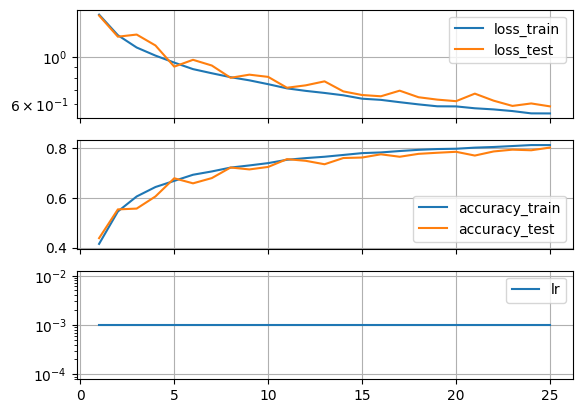

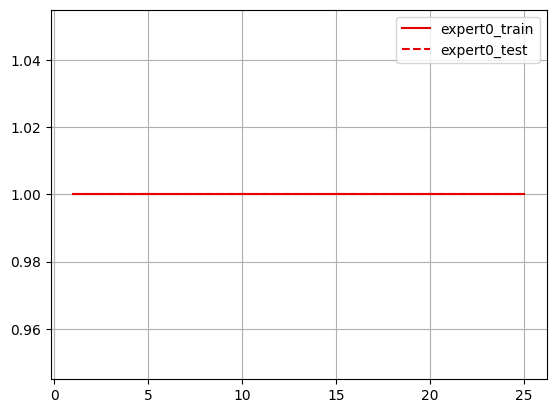

In [1586]:
trainer.history.plot()
trainer.history.plotMoe2Insigths()

In [1587]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[ 973   18   51   12   12    5   13    9   36   21]
 [  18 1108    2    2    2    5    8    1   11   45]
 [  28    3  813   45   27   38   29   13    5    5]
 [  29    5   68  889   56  214   67   40   17   10]
 [  20    1   97   70  973   68   51   68    2   11]
 [   1    2   27  130   17  779   27   20    1    2]
 [   8    1   47   31   27   18  975    2    3    4]
 [  19    4   36   46   57   66    8 1026    6   10]
 [ 104   27   20   18    9    3   15    3 1104   38]
 [  30   80    5   13    3    8    6    6   13  981]]

class: 0, precision:84.61%, hitRate: 79.11%
class: 1, precision:92.18%, hitRate: 88.71%
class: 2, precision:80.82%, hitRate: 69.73%
class: 3, precision:63.73%, hitRate: 70.78%
class: 4, precision:71.49%, hitRate: 82.25%
class: 5, precision:77.44%, hitRate: 64.70%
class: 6, precision:87.37%, hitRate: 81.32%
class: 7, precision:80.28%, hitRate: 86.36%
class: 8, precision:82.33%, hitRate: 92.15%
class: 9, precision:85.68%, hitRate: 87.05%

[
    (0.08995376208490963,

In [1588]:
import winsound
winsound.Beep(200, 300)  # frequency in Hz, duration in ms